# Notebook tính điểm trung bình itemtype = mod
Notebook này tính điểm trung bình từng học sinh từ file `udk_moodle_grades_course_670.csv`, coi `-1` là 0 điểm, chỉ dùng các bản ghi `itemtype = mod`, và vẽ biểu đồ phân phối cùng top học sinh.

In [1]:
# Nạp thư viện và đọc dữ liệu CSV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Đường dẫn tuyệt đối tới file CSV
csv_path = Path('/Users/nguyenhuuloc/Documents/MyComputer/AdaptiveLearning/NCKH/data/data_670/udk_moodle_grades_course_670.csv')

# Đọc dữ liệu
raw_df = pd.read_csv(csv_path)
raw_df_head = raw_df.head()
raw_shape = raw_df.shape
raw_dtypes = raw_df.dtypes

raw_df_head, raw_shape, raw_dtypes

(       id  timemodified  userid  courseid  finalgrade itemtype
 0  344728    1674567497    8860       670           6   course
 1  344727    1674567497    9227       670          -1   course
 2  344726    1674567497    8609       670           9   course
 3  344725    1674567497    9169       670           8   course
 4  344724    1674567497    9043       670           7   course,
 (233, 6),
 id               int64
 timemodified     int64
 userid           int64
 courseid         int64
 finalgrade       int64
 itemtype        object
 dtype: object)

In [23]:
# Tiền xử lý dữ liệu điểm: dùng toàn bộ itemtype, coi -1 là 0
df = raw_df.copy()
df['finalgrade'] = pd.to_numeric(df['finalgrade'], errors='coerce').fillna(-1)
df['finalgrade'] = df['finalgrade'].where(df['finalgrade'] != -1, 0)

# Bỏ các bản ghi thiếu userid hoặc finalgrade
df = df.dropna(subset=['userid', 'finalgrade'])

df_shape = df.shape
df_head = df.head()
df_shape, df_head

((233, 6),
        id  timemodified  userid  courseid  finalgrade itemtype
 0  344728    1674567497    8860       670           6   course
 1  344727    1674567497    9227       670           0   course
 2  344726    1674567497    8609       670           9   course
 3  344725    1674567497    9169       670           8   course
 4  344724    1674567497    9043       670           7   course)

In [25]:
# Tính điểm trung bình từng học sinh (toàn bộ itemtype; -1 -> 0)
# Group theo userid và tính trung bình finalgrade
user_avg = (
    df.groupby('userid', as_index=False)['finalgrade']
    .mean()
    .rename(columns={'finalgrade': 'avg_finalgrade'})
)

# Sắp xếp giảm dần theo điểm trung bình
user_avg_sorted = user_avg.sort_values(by='avg_finalgrade', ascending=False)
user_avg_sorted.head(10)

,userid,avg_finalgrade
1,8609,9.294118
8,9109,9.117647
2,8670,9.000000
14,9169,8.764706
12,9152,8.529412
11,9151,8.294118
7,9043,8.235294
17,9227,8.111111
18,9260,8.058824
10,9146,7.941176


In [26]:
# Tính điểm trung vị (median) từng học sinh (toàn bộ itemtype; -1 -> 0)
# Group theo userid và tính median finalgrade
user_med = (
    df.groupby('userid', as_index=False)['finalgrade']
    .median()
    .rename(columns={'finalgrade': 'med_finalgrade'})
)

# Sắp xếp giảm dần theo median
user_med_sorted = user_med.sort_values(by='med_finalgrade', ascending=False)
user_med_sorted.head(10)

,userid,med_finalgrade
15,9183,10.0
8,9109,10.0
12,9152,10.0
1,8609,10.0
2,8670,9.5
18,9260,9.0
11,9151,9.0
17,9227,9.0
16,9220,9.0
14,9169,9.0


In [27]:
# Phân loại 3 mức điểm và tính tỉ lệ (Yếu <5, Trung bình 5-8.49, Giỏi ≥8.5)
import numpy as np

# Định nghĩa hàm phân loại
bins = [0, 5, 8.5, np.inf]
labels = ['Yếu', 'Trung bình', 'Giỏi']
user_avg_sorted['level'] = pd.cut(user_avg_sorted['avg_finalgrade'], bins=bins, labels=labels, right=False)

level_counts = user_avg_sorted['level'].value_counts().reindex(labels, fill_value=0)
level_pct = (level_counts / level_counts.sum() * 100).round(2)

level_summary = pd.DataFrame({
    'count': level_counts,
    'percent': level_pct
})
level_summary

,count,percent
level,,
Yếu,5,23.81
Trung bình,11,52.38
Giỏi,5,23.81


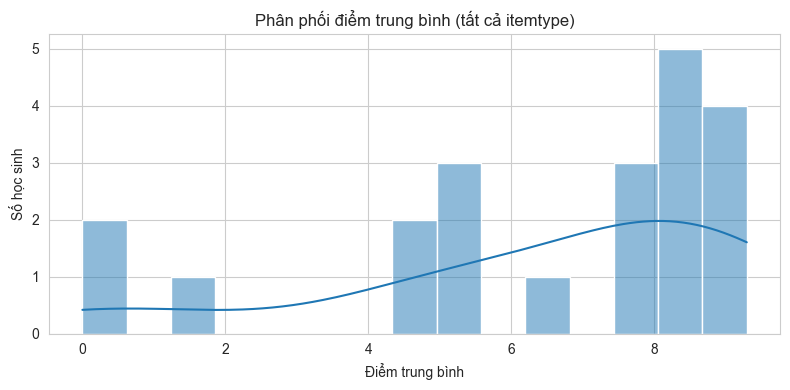

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_35466/2468392827.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicit

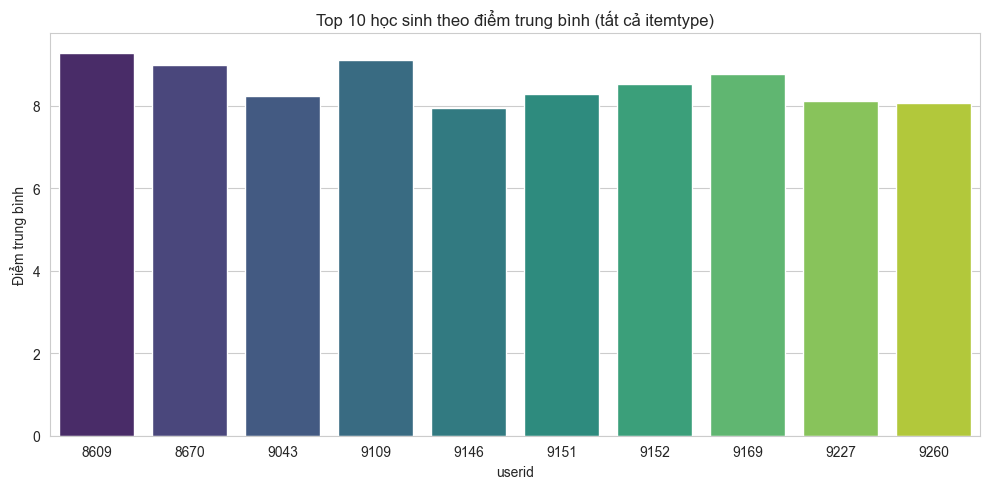

In [29]:
# Vẽ biểu đồ phân phối và top học sinh theo điểm trung bình (toàn bộ itemtype)
sns.set_style('whitegrid')

# Histogram phân phối điểm trung bình
plt.figure(figsize=(8, 4))
sns.histplot(user_avg_sorted['avg_finalgrade'], bins=15, kde=True, color='#1f77b4')
plt.title('Phân phối điểm trung bình (tất cả itemtype)')
plt.xlabel('Điểm trung bình')
plt.ylabel('Số học sinh')
plt.tight_layout()
plt.show()

# Bar chart top 10 học sinh
top_n = 10
plt.figure(figsize=(10, 5))
sns.barplot(
    data=user_avg_sorted.head(top_n),
    x='userid', y='avg_finalgrade', palette='viridis'
)
plt.title(f'Top {top_n} học sinh theo điểm trung bình (tất cả itemtype)')
plt.xlabel('userid')
plt.ylabel('Điểm trung bình')
plt.tight_layout()
plt.show()

In [19]:
# Chẩn đoán: kiểm tra số lượng điểm và tỷ lệ điểm cao (≥9) theo học sinh

# Đếm số bản ghi và tỷ lệ điểm cao
per_user_stats = df.groupby('userid').agg(
    n_grades=('finalgrade','size'),
    pct_high=('finalgrade', lambda s: (s>=9).mean()*100),
    mean_grade=('finalgrade','mean')
).reset_index()

per_user_stats.sort_values('pct_high', ascending=False).head(10)

,userid,n_grades,pct_high,mean_grade
1,8609,17,82.352941,9.294118
8,9109,17,76.470588,9.117647
14,9169,17,70.588235,8.764706
2,8670,10,70.000000,9.000000
17,9227,9,66.666667,8.111111
12,9152,17,58.823529,8.529412
7,9043,17,58.823529,8.235294
11,9151,17,58.823529,8.294118
15,9183,11,54.545455,7.909091
16,9220,17,52.941176,7.705882


In [14]:
# Chẩn đoán: kiểm tra trùng lặp theo (userid, timemodified, itemtype)

dup_mask = df.duplicated(subset=['userid','timemodified','itemtype'], keep=False)

duplicates = df.loc[dup_mask].sort_values(['userid','timemodified'])

# Hiển thị vài dòng trùng lặp (nếu có)

duplicates.head(20)

,id,timemodified,userid,courseid,finalgrade,itemtype
29,343490,1674217370,8860,670,1,mod
30,343489,1674217370,8860,670,9,mod
26,343493,1674217553,8860,670,1,mod
27,343492,1674217553,8860,670,1,mod
28,343491,1674217553,8860,670,0,mod


In [20]:
# Trung bình theo từng (userid, itemtype) trước, rồi trung bình theo userid

item_user_avg = df.groupby(['userid','itemtype'], as_index=False)['finalgrade'].mean()

user_avg_2step = (
    item_user_avg.groupby('userid', as_index=False)['finalgrade']
    .mean()
    .rename(columns={'finalgrade':'avg_finalgrade_2step'})
)

# So sánh với cách trung bình trực tiếp

compare_avg = user_avg_sorted.merge(user_avg_2step, on='userid', how='left')

compare_avg.head(10)

,userid,avg_finalgrade,level,avg_finalgrade_2step
0,8609,9.294118,Giỏi,9.156250
1,9109,9.117647,Giỏi,8.593750
2,8670,9.000000,Giỏi,8.555556
3,9169,8.764706,Giỏi,8.406250
4,9152,8.529412,Giỏi,8.281250
5,9151,8.294118,Giỏi,8.156250
6,9043,8.235294,Giỏi,7.656250
7,9227,8.111111,Giỏi,4.562500
8,9260,8.058824,Giỏi,7.562500
9,9146,7.941176,Trung bình,7.500000


In [21]:
# Phân loại theo median và tính tỉ lệ (Yếu <5, Trung bình 5-8.49, Giỏi ≥8.5)

bins = [0, 5, 8.5, np.inf]

labels = ['Yếu', 'Trung bình', 'Giỏi']

user_med_sorted['level_med'] = pd.cut(user_med_sorted['med_finalgrade'], bins=bins, labels=labels, right=False)

level_med_counts = user_med_sorted['level_med'].value_counts().reindex(labels, fill_value=0)

level_med_pct = (level_med_counts / level_med_counts.sum() * 100).round(2)

level_med_summary = pd.DataFrame({

    'count_med': level_med_counts,

    'percent_med': level_med_pct

})

level_med_summary

,count_med,percent_med
level_med,,
Yếu,3,14.29
Trung bình,5,23.81
Giỏi,13,61.90
